# 230968078 - Ishan Suryawanshi - Week 2 - Question 2

In [1]:
!pip install keras_tuner

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras_tuner as kt
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

2025-08-13 13:04:13.601932: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1755090253.845401      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1755090253.917369      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [127]:
df = pd.read_csv('/kaggle/input/housingdata/HousingData.csv')
df.head()

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1,296,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2,242,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2,242,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3,222,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3,222,18.7,396.90,NaN,36.2


In [128]:
df.isnull().sum()

CRIM       20
ZN         20
INDUS      20
CHAS       20
NOX         0
RM          0
AGE        20
DIS         0
RAD         0
TAX         0
PTRATIO     0
B           0
LSTAT      20
MEDV        0
dtype: int64

In [129]:
df = df.dropna()

In [130]:
num_vars = ['CRIM', 'ZN', 'INDUS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']

In [131]:
df.shape

(394, 14)

In [132]:
# removing the outliers because it is really decreasing the sample count
for i in num_vars:
  q1 = df[i].quantile(0.25)
  q3 = df[i].quantile(0.75)
  iqr = q3 - q1

  lb = q1 - (2.5 * iqr)
  ub = q3 + (2.5 * iqr)

  df = df[(df[i] >= lb) & (df[i] <= ub)]

In [133]:
x = df.drop('MEDV', axis = 1)
y = df['MEDV']

In [134]:
# splittig into train test and validation set
x_train, x_temp, y_train, y_temp = train_test_split(x, y, test_size=0.2, random_state=42)
x_test, x_val, y_test, y_val = train_test_split(x_temp, y_temp, test_size=0.5, random_state=42)

In [135]:
scaler = StandardScaler()
x_train[num_vars] = scaler.fit_transform(x_train[num_vars])
x_val[num_vars] = scaler.transform(x_val[num_vars])
x_test[num_vars] = scaler.transform(x_test[num_vars])

In [136]:
x_train.shape

(187, 13)

In [137]:
def build_model(hp):
  model = Sequential()
  num_layers = hp.Choice('layers', [1, 2, 3])
  reg_type = hp.Choice('regularization', ['none', 'l1', 'l2'])
  if reg_type == 'l1':
    reg = regularizers.l1(0.01)
  elif reg_type == 'l2':
    reg = regularizers.l2(0.01)
  else:
    reg = None

  model.add(Dense(128, activation='relu', kernel_regularizer=reg, input_shape=(13,)))
  if num_layers >= 2:
    model.add(Dense(64, activation='relu', kernel_regularizer=reg))
  if num_layers == 3:
    model.add(Dense(32, activation='relu', kernel_regularizer=reg))
  model.add(Dense(1))

  lr = hp.Choice('learning_rate', [0.1, 0.01, 0.001])
  model.compile(
      optimizer = Adam(learning_rate=lr),
      loss = 'mse',
      metrics=['mse']
  )
  return model

In [138]:
results = []

for ep in [10, 20, 30]:
  tuner = kt.BayesianOptimization(
      build_model,
      objective='val_mse',
      max_trials=10,
      executions_per_trial=1,
      overwrite=True
  )

  tuner.search(
      x_train, y_train,
      validation_data=(x_val, y_val),
      epochs=ep,
      callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
      verbose=1
  )

  best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
  best_model = tuner.get_best_models(num_models=1)[0]
  loss, mse = best_model.evaluate(x_val, y_val, verbose=0)

  results.append({
        "epochs": ep,
        "layers": best_hps.get("layers"),
        "regularization": best_hps.get("regularization"),
        "learning_rate": best_hps.get("learning_rate"),
        "val_mse": mse
    })

Trial 10 Complete [00h 00m 10s]
val_mse: 7.100317478179932

Best val_mse So Far: 4.05700159072876
Total elapsed time: 00h 01m 23s


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [139]:
results

[{'epochs': 10,
  'layers': 1,
  'regularization': 'l2',
  'learning_rate': 0.1,
  'val_mse': 7.368777751922607},
 {'epochs': 20,
  'layers': 1,
  'regularization': 'l1',
  'learning_rate': 0.1,
  'val_mse': 2.9275200366973877},
 {'epochs': 30,
  'layers': 2,
  'regularization': 'none',
  'learning_rate': 0.1,
  'val_mse': 4.05700159072876}]

In [140]:
# we can see that we got the best results from choosing 30 epochs
best_result = min(results, key=lambda x: x['val_mse'])

In [141]:
best_result

{'epochs': 20,
 'layers': 1,
 'regularization': 'l1',
 'learning_rate': 0.1,
 'val_mse': 2.9275200366973877}

In [142]:
def build_best_model(layers, regularization, lr):
    model = Sequential()
    model.add(Dense(128, activation="relu"))
    if layers >= 2:
        model.add(Dense(64, activation="relu"))
    if layers == 3:
        model.add(Dense(32, activation="relu"))
    if regularization != "none":
        reg = regularizers.l1(0.01) if regularization == "l1" else regularizers.l2(0.01)
        for layer in model.layers:
            if isinstance(layer, Dense):
                layer.kernel_regularizer = reg

    model.add(Dense(1))

    optimizer = Adam(learning_rate=lr)
    model.compile(optimizer=optimizer, loss="mse", metrics=["mse"])
    return model

In [143]:
best_model = build_best_model(
    layers=best_result["layers"],
    regularization=best_result["regularization"],
    lr=best_result["learning_rate"]
)

In [146]:
history = best_model.fit(
    x_train, y_train,
    validation_data=(x_val, y_val),
    epochs=best_result['epochs'],
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)],
    verbose=1
)

Epoch 1/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - loss: 8.0429 - mse: 3.5542 - val_loss: 8.4868 - val_mse: 4.0673
Epoch 2/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 7.0662 - mse: 2.6665 - val_loss: 9.8891 - val_mse: 5.5516
Epoch 3/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 7.4286 - mse: 3.1128 - val_loss: 7.4098 - val_mse: 3.1644
Epoch 4/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.3334 - mse: 2.1083 - val_loss: 7.6627 - val_mse: 3.5024
Epoch 5/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 6.9678 - mse: 2.8270 - val_loss: 7.7149 - val_mse: 3.6437
Epoch 6/20
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 6.4302 - mse: 2.3775 - val_loss: 9.2652 - val_mse: 5.2781


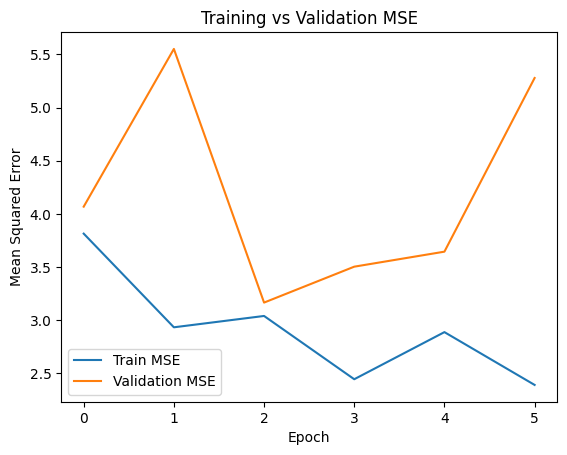

In [147]:
plt.plot(history.history['mse'], label='Train MSE')
plt.plot(history.history['val_mse'], label='Validation MSE')
plt.title("Training vs Validation MSE")
plt.xlabel("Epoch")
plt.ylabel("Mean Squared Error")
plt.legend()
plt.show()

In [148]:
y_pred = best_model.predict(x_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


In [149]:
test_mse = mean_squared_error(y_test, y_pred)
test_rmse = np.sqrt(test_mse)
test_mae = mean_absolute_error(y_test, y_pred)
test_r2 = r2_score(y_test, y_pred)

print("\n===== Test Set Metrics =====")
print(f"MSE:   {test_mse:.4f}")
print(f"RMSE:  {test_rmse:.4f}")
print(f"MAE:   {test_mae:.4f}")
print(f"R²:    {test_r2:.4f}")


===== Test Set Metrics =====
MSE:   6.0934
RMSE:  2.4685
MAE:   1.7178
R²:    0.8828
